In [50]:
#loading libraries

%matplotlib inline
import matplotlib.pyplot as plt
import time
import shutil
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
import os
import cv2
import argparse
import math
import statistics
import random 

from PIL import Image
from tqdm import tqdm

from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
import copy

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torchvision.datasets import ImageFolder
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from torchsummary import summary
np.random.seed(0)

In [20]:
os.path.abspath('Plant Seedling Classification')

'C:\\Users\\anil\\Project (Kaggle)\\Plant seedling classification\\Plant Seedling Classification'

## Data Loader for Training

In [25]:
#for loading datasets giving path
path = os.path.abspath('Plant Seedling Classification\\')
train_dir = os.path.join(os.path.dirname(path), "train")
test_dir = os.path.join(os.path.dirname(path), "test")

## Exploratory Data Analysis (EDA)

In [26]:
# resizing the images to 224 x 224 to reduce computational overhead
transform = transforms.Compose(
    [transforms.Resize([224,224])
    ])
train_data = datasets.ImageFolder(train_dir, transform=transform)

In [27]:
# converting classes to ids

print(train_data.class_to_idx)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [28]:
#giving ids to each class ---------------> storing values of ids 

idx_to_class = {value: key for key, value in train_data.class_to_idx.items()}
image_paths = [item[0] for item in train_data.imgs]

In [29]:
#shape and length of the training data

image_shape = np.array(train_data[0][0]).shape
data_length = len(train_data)

In [30]:
print('\nLength of the dataset:',data_length)


Length of the dataset: 4750


In [31]:
#Making empty labels and data 

data_shape = list(image_shape)
data_shape.insert(0, data_length)

data = np.zeros(data_shape, dtype=np.uint8)

labels = np.zeros([data_length], dtype=np.int64)

In [32]:
# Reading images according to their labels

i = 0
for image, label in tqdm(train_data, desc="Reading Images"):
    data[i] = np.array(image)
    labels[i] = label
    i += 1

Reading Images: 100%|██████████| 4750/4750 [01:01<00:00, 77.03it/s] 


In [33]:
# Creatig dictionary where train_dict contains data ,labels and shape, train_info contains ids and image paths 

train_dict = {"data": data, "labels": labels, 'data_shape': image_shape}
train_info = {"label_names": idx_to_class, "file_paths": image_paths}

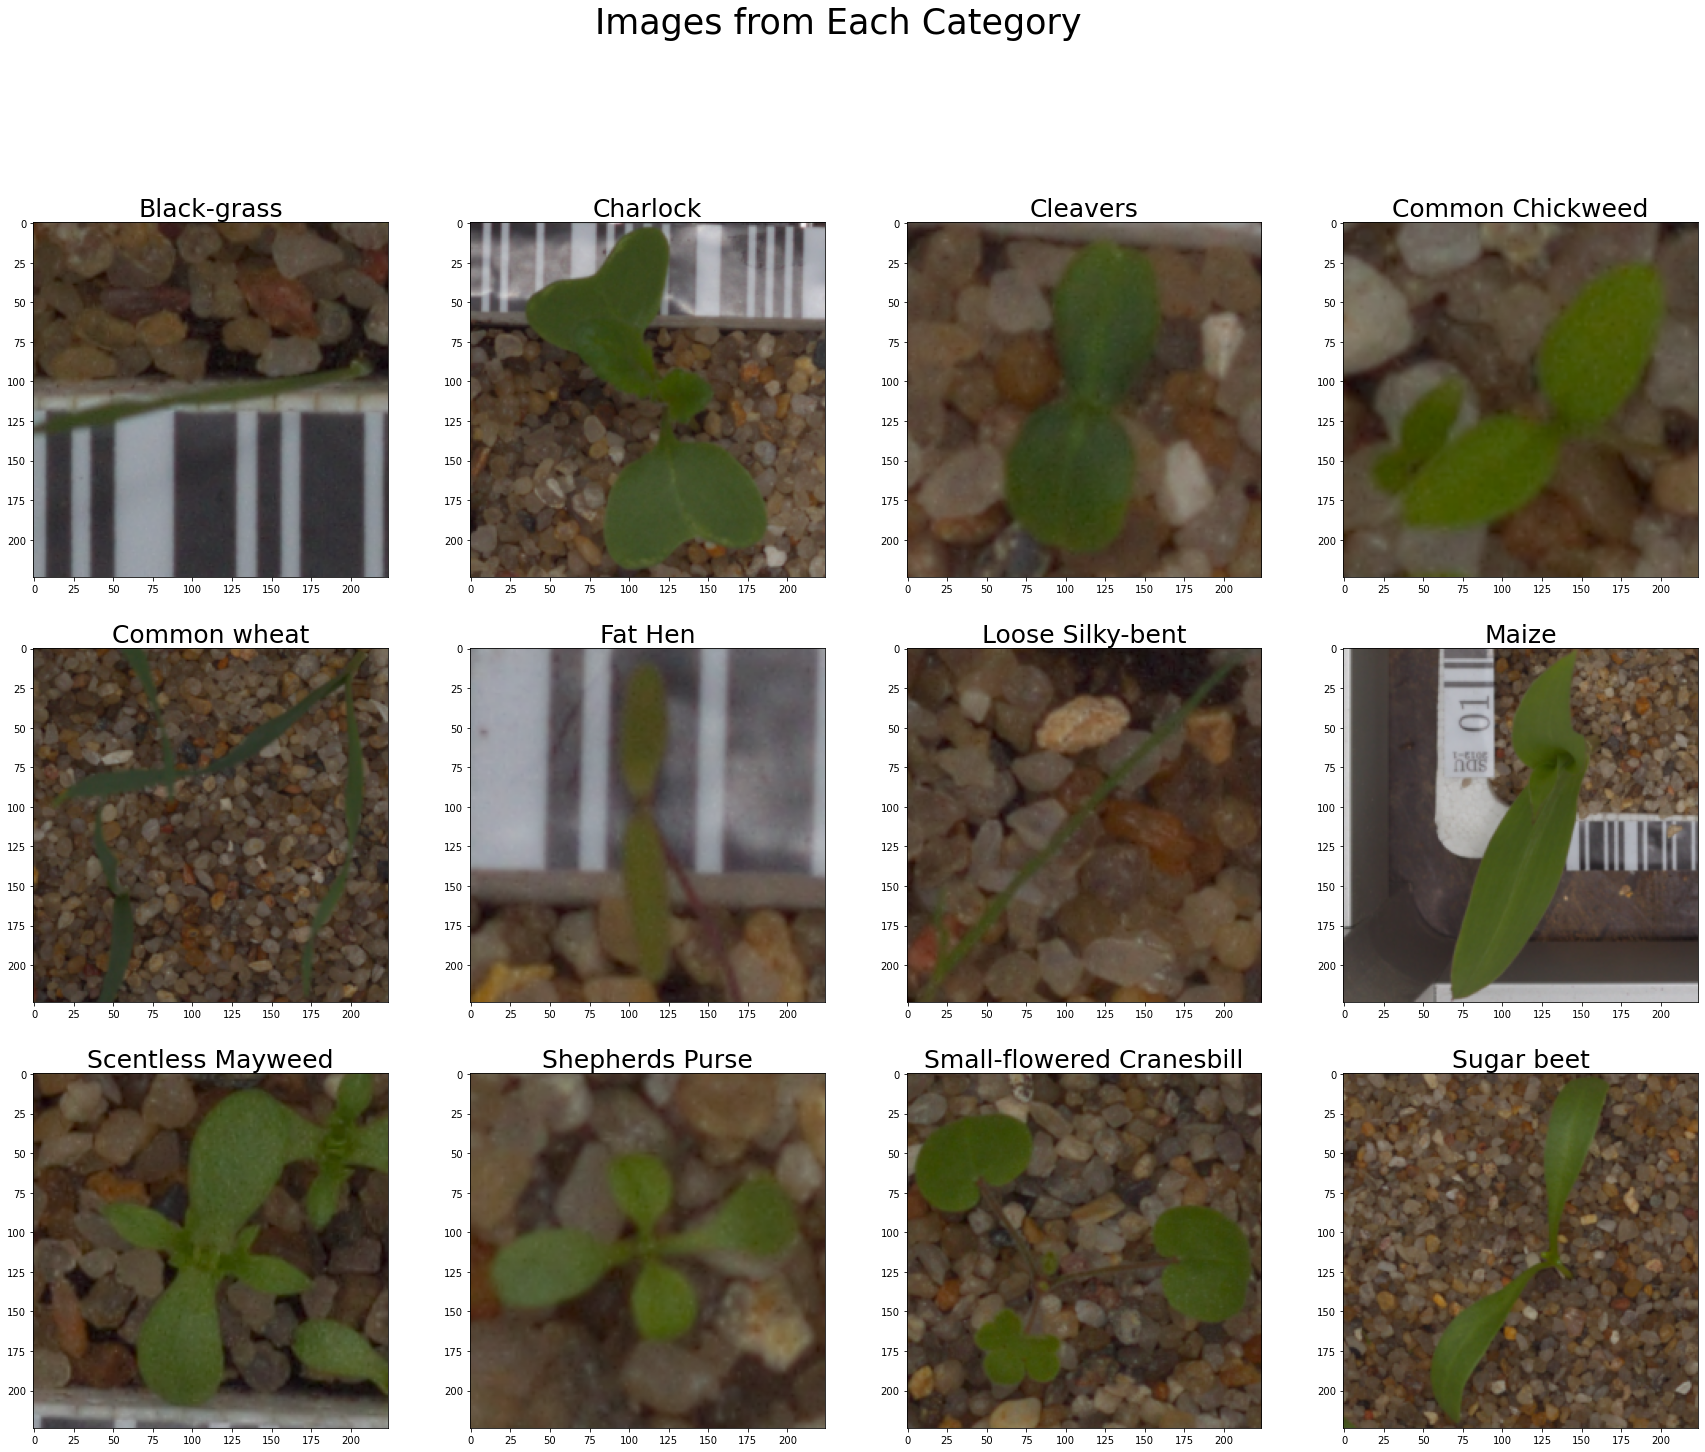

In [34]:
#Displaying images of each class 

plt.figure(figsize=(30,30))
count = 0 
i =0 
while count<12:
    
    if count==train_dict["labels"][i]:
        
        plt.suptitle('Images from Each Category',fontsize=35)
        plt.subplot(4,4,count+1)
        plt.imshow(train_dict["data"][i])
        plt.title(train_info["label_names"][train_dict["labels"][i]],fontsize=25)
        count += 1
        
    else:
        i += 1  

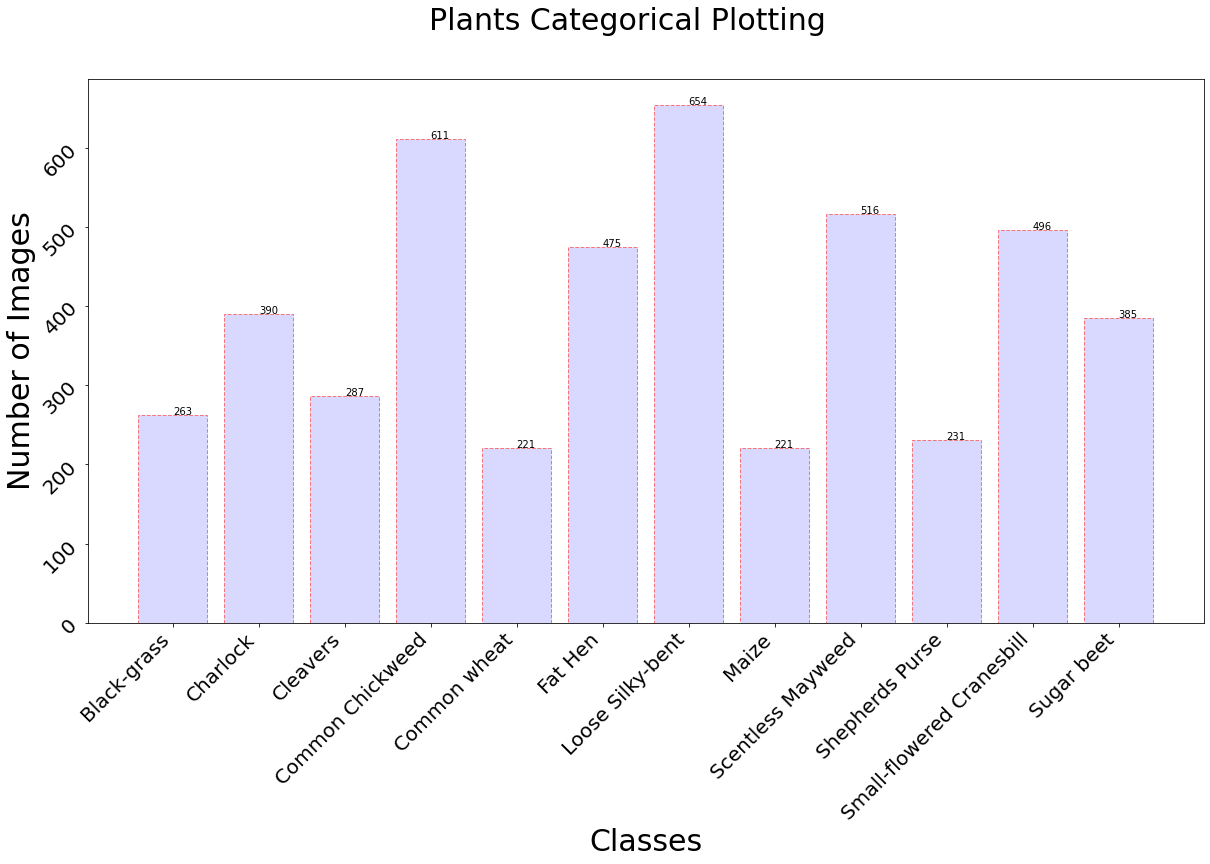

In [36]:
#Plotting the histogram for each category with it's count

labels=[]
values =[]

for label in np.unique(train_dict["labels"]):
    
    values.append(len(train_dict["data"][train_dict["labels"] == label]))
    labels.append(train_info["label_names"][label])
    
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(labels, values,color=(0,0,1,0.15),ls='dashed', lw=1, edgecolor = (1,0,0,0.5))

plt.xticks(rotation=45, ha='right',fontsize=20)
plt.yticks(rotation=45, ha='right',fontsize=20)

fig.suptitle('Plants Categorical Plotting',fontsize=30)
ax.set_xlabel("Classes",fontsize=30)
ax.set_ylabel("Number of Images",fontsize=30)
i =0
for v in labels:
    plt.text(v, values[i], str(values[i]))
    i += 1

## Digital Image Processing:

In [37]:
# Apply image processing on the images
def masking(image):
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# segmentation
#The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
def segmentation(image):
    
    mask = masking(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output

# Sharpening an image increases the contrast between bright and dark regions to bring out features.
def sharpen(image):
    
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    
    return image_sharp

def segment(img):
    
    image_segmented = segmentation(img)
    image_sharpen = sharpen(image_segmented)
    
    return image_sharpen

<Figure size 2160x2160 with 0 Axes>

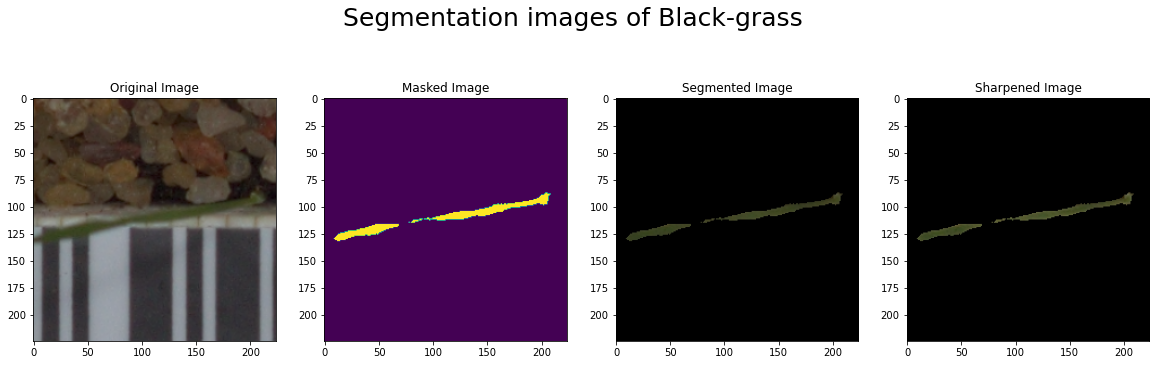

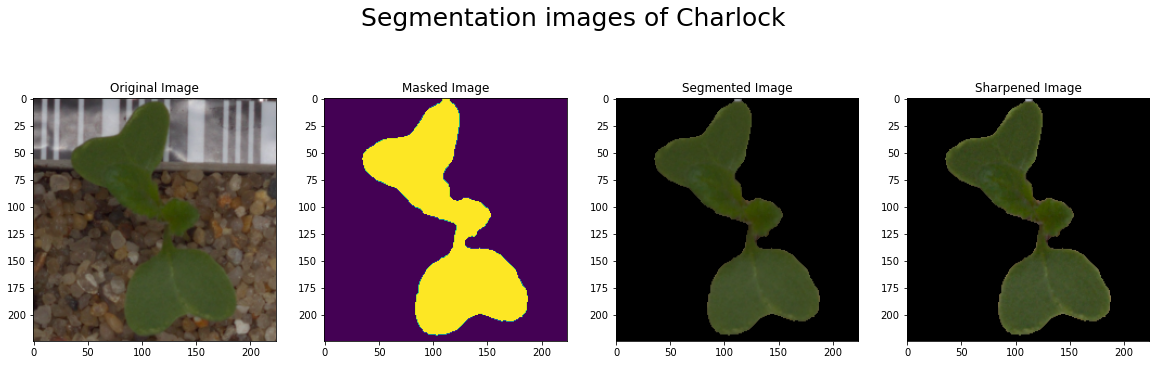

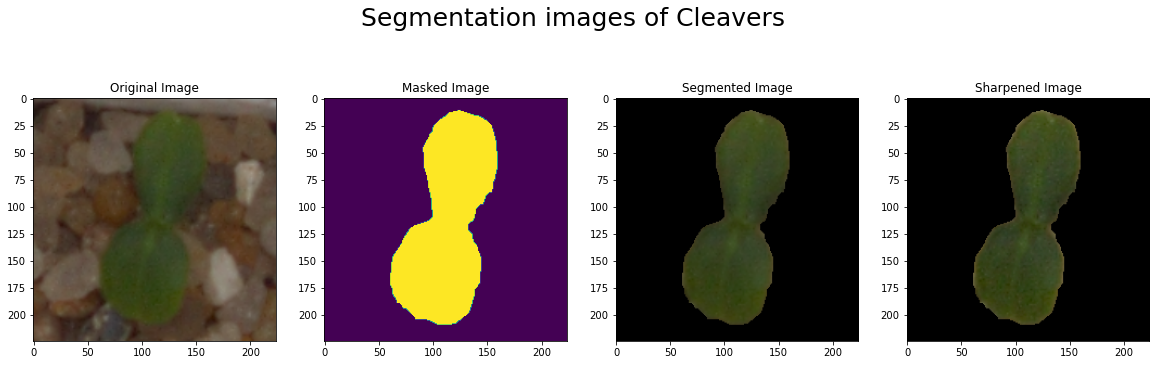

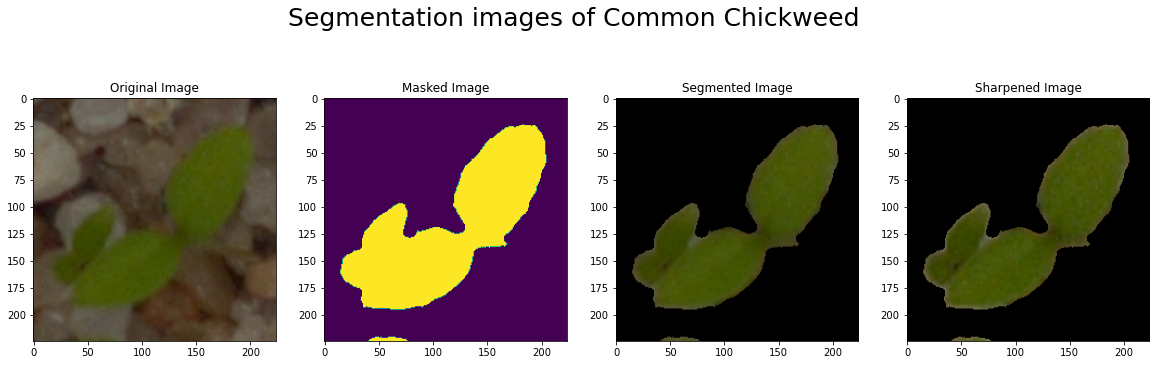

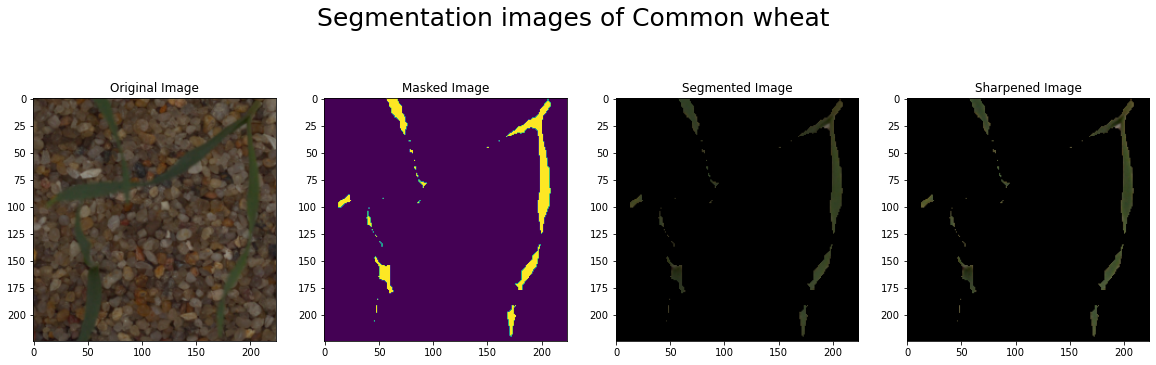

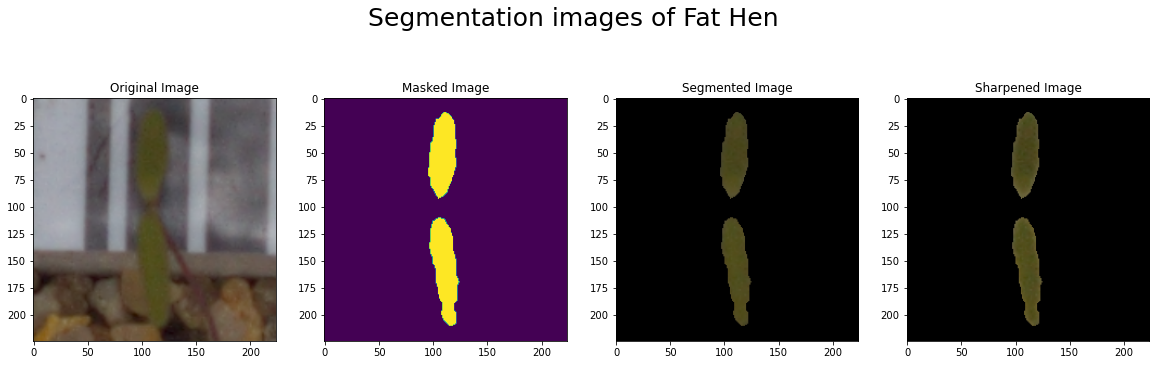

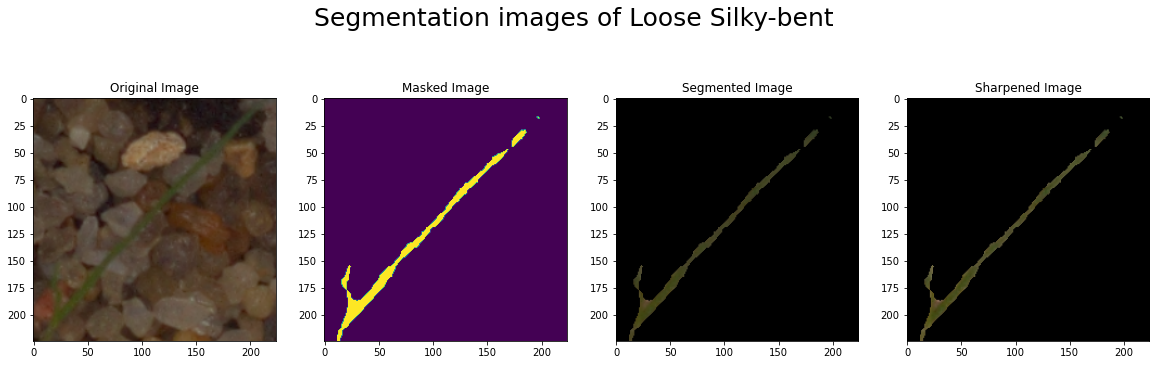

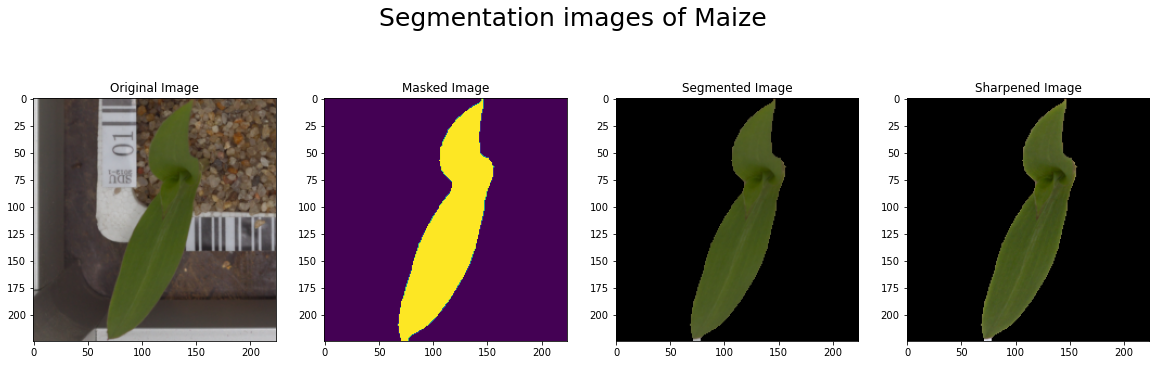

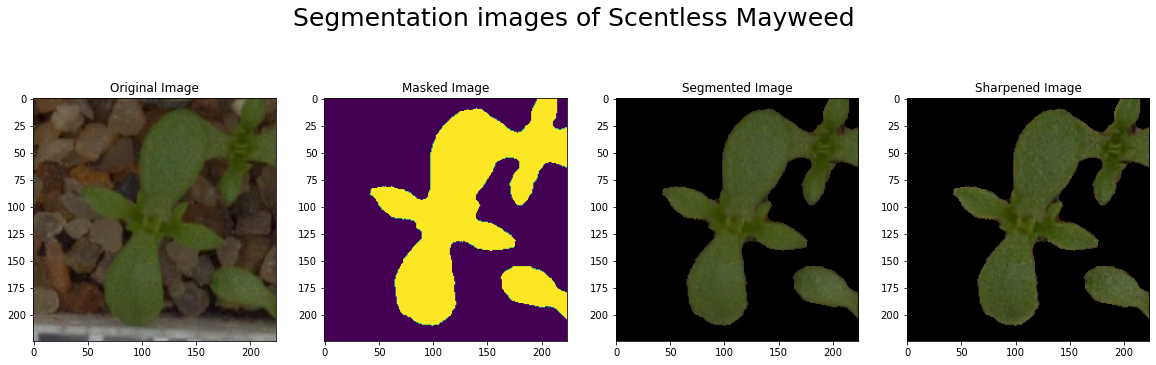

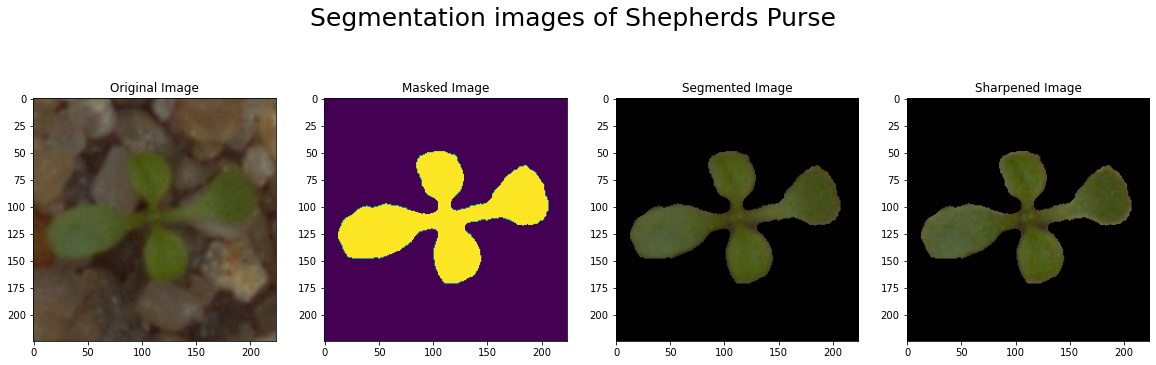

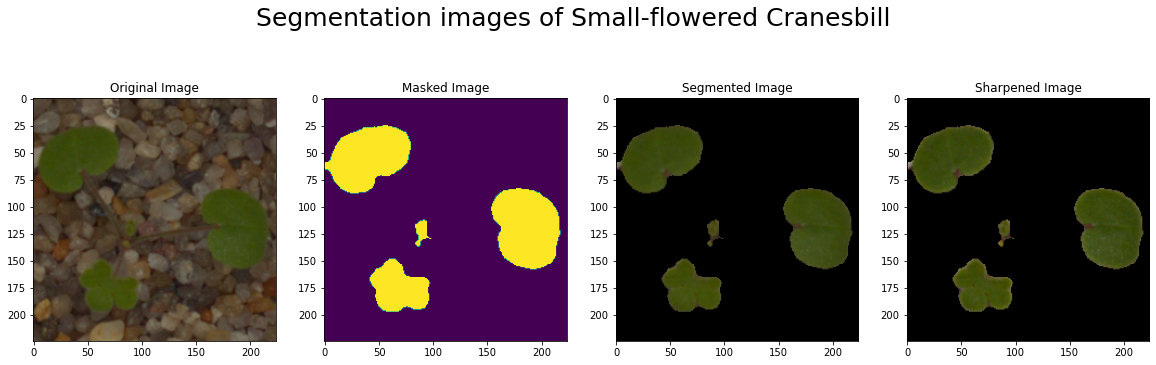

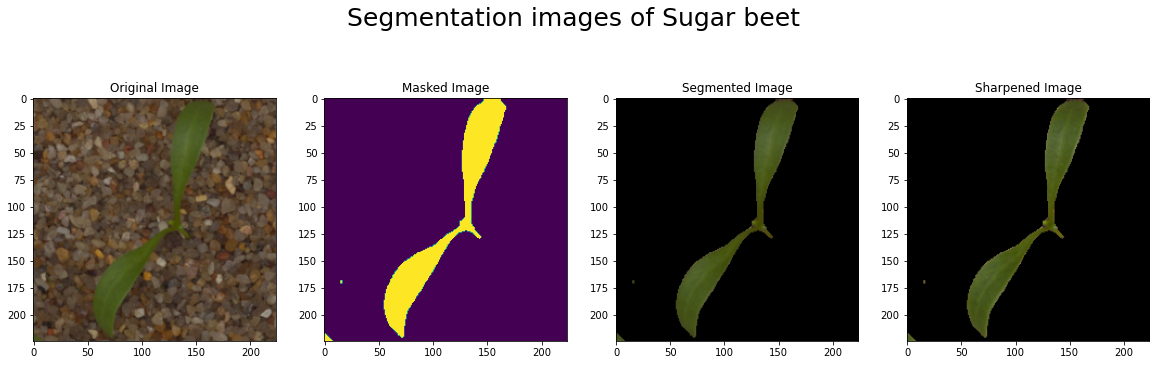

In [38]:
# Displaying images of each class

plt.figure(figsize=(30,30))
count = 0 
i =0

while count<12:
    
    if count==train_dict["labels"][i]:
        
        image = train_dict["data"][i]
        image_mask = masking(image)
        image_segmented = segmentation(image)
        image_sharpen = sharpen(image_segmented)
        
        fig, axs = plt.subplots(1, 4, figsize=(20, 20))
        plt.suptitle("Segmentation images of " + train_info["label_names"][train_dict["labels"][i]],fontsize=25,y=0.65)
        
        axs[0].set_title("Original Image")
        axs[0].imshow(image)
        
        axs[1].set_title("Masked Image")
        axs[1].imshow(image_mask)
        
        axs[2].set_title("Segmented Image")
        axs[2].imshow(image_segmented)
        
        axs[3].set_title("Sharpened Image")
        axs[3].imshow(image_sharpen)
        count += 1
    else:
        i += 1

In [39]:
for i in range(len(train_dict["data"])):
    train_dict["data"][i]=segment(train_dict["data"][i])

## Focal Loss

This gives model freedom to take some risk while prediction, this would help us handle the imbalance classes. The risk is that it will predict something even if the prediction turns out to be a False Positive

In [40]:
#Focal loss will handle the class imbalance part

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = torch.Tensor([gamma])
        self.size_average = size_average
        if isinstance(alpha, (float, int, long)):
            if self.alpha > 1:
                raise ValueError('Not supported value, alpha should be small than 1.0')
            else:
                self.alpha = torch.Tensor([alpha, 1.0 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.alpha /= torch.sum(self.alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # [N,C,H,W]->[N,C,H*W] ([N,C,D,H,W]->[N,C,D*H*W])
        # target
        # [N,1,D,H,W] ->[N*D*H*W,1]
        if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
        target = target.view(-1, 1)
        logpt = torch.log(input + 1e-10)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1, 1)
        pt = torch.exp(logpt)
        alpha = self.alpha.gather(0, target.view(-1))

        gamma = self.gamma

        if not self.gamma.device == input.device:
            gamma = torch.tensor(self.gamma, device=input.device)

        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [41]:
# Converting to tensor
class ImageToTensor(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.to_tensor = torchvision.transforms.ToTensor()
    def __getitem__(self, index):
        return self.to_tensor(self.x_data[index]), self.y_data[index]
    def __len__(self):
        return len(self.x_data)

In [43]:
image_dataset = ImageToTensor(train_dict["data"], train_dict["labels"])

print('\nPrinting shape:')
print(image_dataset[0][0].shape,'\n\n')

print('\nPrinting Tensor:')
print(image_dataset[4610])


Printing shape:
torch.Size([3, 224, 224]) 



Printing Tensor:
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 11)


In [44]:
# Dividing the data into training set and validation set 

def testVal_split(array, pick_num):
    
    index = np.arange(len(array))
    pick = np.random.choice(len(array), pick_num, replace=False)
    unpick = np.equal(np.in1d(index, pick), False)
    return array[unpick], array[pick]

# we are doing 90:10% split for train & validation

train_mask, valid_mask = testVal_split(np.arange(len(image_dataset)), 475)
train_set = torch.utils.data.Subset(image_dataset, train_mask)
valid_set = torch.utils.data.Subset(image_dataset, valid_mask)

#Printing the output

print('\nLength of Training dataset: ',len(train_set))

print('\nLength of Validation dataser: ',len(valid_set))



Length of Training dataset:  4275

Length of Validation dataser:  475


In [45]:
#Dataloader

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, shuffle=False)

## Modeling

In [47]:
#Creating Model -> CNN

class ConvNet(nn.Module):
    
    def __init__(self):
        
        super(ConvNet, self).__init__()
        
        # Starting with sequential model
        self.cnn_layers = nn.Sequential(
            # Convolutional layer 2-d with 3 neurons
            nn.Conv2d(3, 6, 5),
            # Normalizer layer
            nn.BatchNorm2d(6),
            # Max Pooling layer to generalize our data
            nn.MaxPool2d(2, 2),
            # Droupout layer to decrease overfitting
            nn.Dropout(0.5),
            # 2nd Convolutional layer 2-d with 6 neurons
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
            # 3rd Convolutional layer 2-d with 16 neurons
            nn.Conv2d(16, 32, 5)
        )  
        
        # Using Relu activation function
        self.linear_layers = nn.Sequential(
            nn.Linear(32 * 49 * 49, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, len(np.unique(train_dict["labels"])))
        )             
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

print('\n Created Convolutional Neural Network Model (CNN)')

# Setting parameters for CNN

#Model Parameters
net = ConvNet()
#Loss Function
criterion = nn.CrossEntropyLoss()
#SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)


 Created Convolutional Neural Network Model (CNN)


In [51]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
       BatchNorm2d-2          [-1, 6, 220, 220]              12
         MaxPool2d-3          [-1, 6, 110, 110]               0
           Dropout-4          [-1, 6, 110, 110]               0
            Conv2d-5         [-1, 16, 106, 106]           2,416
       BatchNorm2d-6         [-1, 16, 106, 106]              32
         MaxPool2d-7           [-1, 16, 53, 53]               0
           Dropout-8           [-1, 16, 53, 53]               0
            Conv2d-9           [-1, 32, 49, 49]          12,832
           Linear-10                  [-1, 512]      39,338,496
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 100]          51,300
             ReLU-13                  [-1, 100]               0
           Linear-14                   

C:\Users\anil\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [52]:
print('Training CNN with 10 epochs')
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

Training CNN with 10 epochs
[1,    50] loss: 2.4982
[1,   100] loss: 2.4018
[1,   150] loss: 2.4454
[1,   200] loss: 2.3598
[1,   250] loss: 2.4378
[1,   300] loss: 2.3911
[1,   350] loss: 2.4161
[1,   400] loss: 2.1265
[1,   450] loss: 2.3882
[1,   500] loss: 2.2528
[1,   550] loss: 2.2661
[1,   600] loss: 2.3650
[1,   650] loss: 2.1641
[1,   700] loss: 2.0613
[1,   750] loss: 2.2074
[1,   800] loss: 2.3259
[1,   850] loss: 2.3095
[1,   900] loss: 1.9436
[1,   950] loss: 1.8174
[1,  1000] loss: 1.9296
[1,  1050] loss: 1.9765
[1,  1100] loss: 2.1029
[1,  1150] loss: 1.9404
[1,  1200] loss: 1.8416
[1,  1250] loss: 2.0037
[1,  1300] loss: 1.9682
[1,  1350] loss: 1.9472
[1,  1400] loss: 2.0723
[1,  1450] loss: 2.0904
[1,  1500] loss: 1.9818
[1,  1550] loss: 1.9039
[1,  1600] loss: 1.7549
[1,  1650] loss: 1.9933
[1,  1700] loss: 1.9320
[1,  1750] loss: 1.6911
[1,  1800] loss: 1.6696
[1,  1850] loss: 1.8315
[1,  1900] loss: 1.9006
[1,  1950] loss: 1.6313
[1,  2000] loss: 1.7569
[1,  2050] l

In [53]:
# Saving model

os.makedirs("CNN", exist_ok=True)
torch.save(net.state_dict(), 'CNN/simple_cnn.pth')

In [54]:
# Loading model

net = ConvNet()
net.load_state_dict(torch.load('CNN/simple_cnn.pth'))

<All keys matched successfully>

In [55]:
# checking on validation set

print('Checking accuracy of Convolutional Neural Network on Vaidation set\n')

correct = 0
top3 = 0
total = 0

with torch.no_grad():
    for i in range(len(valid_loader)):
        try:
            
            images, label = valid_set.__getitem__(i)
            images = images[None, :, :]
            predictions = net(images).numpy()[0].argsort()[::-1]
            
            if label == predictions[0]:
                correct += 1
            if label in predictions[:3]:
                top3 += 1
            total += 1
        except:
            print('exception')
            
print('Accuracy of the network on the validation images: %d %%' % (100 * top3 / total))

Checking accuracy of Convolutional Neural Network on Vaidation set

Accuracy of the network on the validation images: 93 %


In [56]:
# Dataloader for Test Dataset


print('Test Dataset Loader\n')

class TestDataset_Loader(Dataset):
    
    # Initializing the data paths and getting images
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = [os.path.join(self.data_path, dI) for dI in os.listdir(self.data_path)]
    
    # Getting image length
    def __len__(self):
        return len(self.images)
    
    # getting each item and doing transformation
    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img

"""""""""""""""""""""""""""""""""""""""


Test Dataset Loader


"""""""""""""""""""""""""""""""""""""""




In [57]:
# test transform same as train

test_transforms = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.ToPILImage()
])
test_dataset = TestDataset_Loader(
    test_dir, 
    transform=test_transforms)

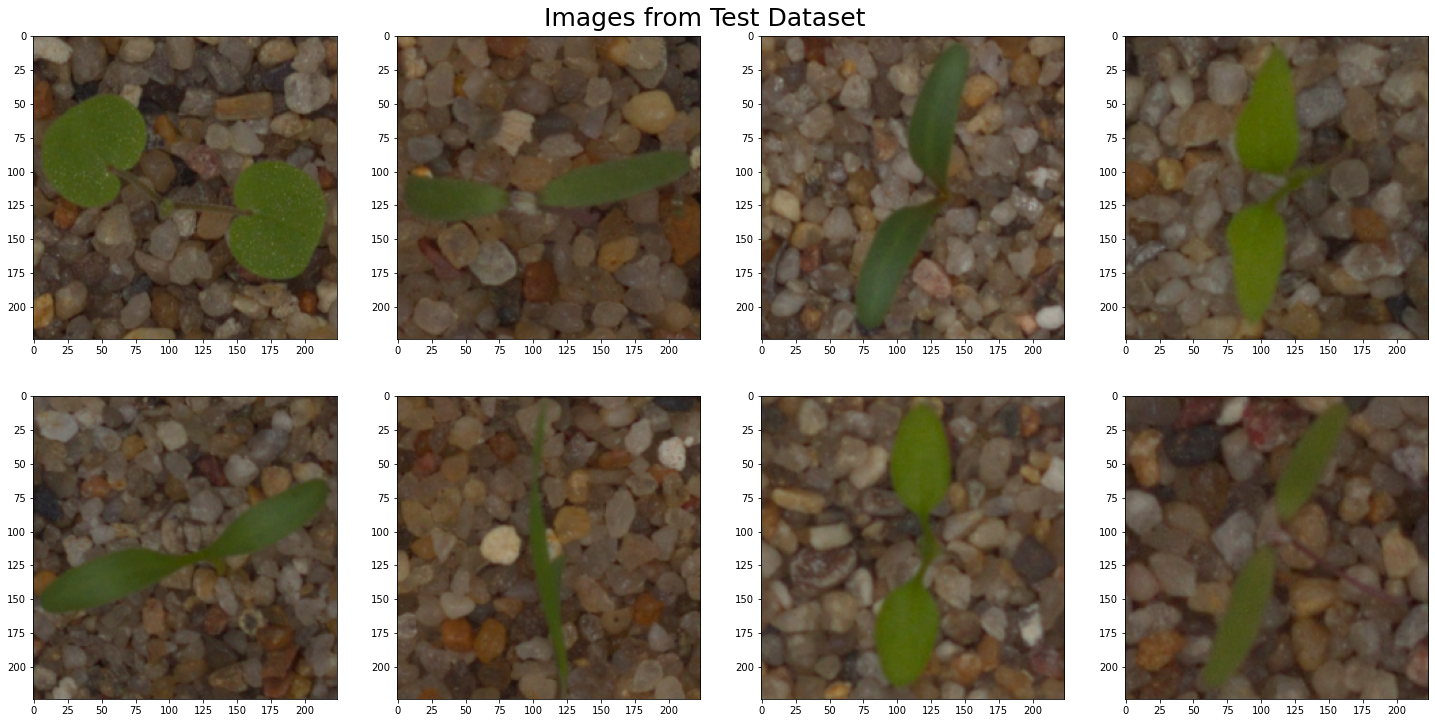

In [58]:
#Printing some test images

plt.figure(figsize=(25,25))
plt.suptitle('Images from Test Dataset ',fontsize=25,y=0.7)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    plt.imshow(test_dataset[i])

In [59]:
# Applying segmentation on test images 

test_da = []
for i in range(len(test_dataset)):
    
    test_da.append(segment(np.asarray(test_dataset[i])))

In [60]:
#Converting to tensors
test_dataset = ImageToTensor(test_da, train_dict["labels"])

print('\nShape of Test Dataset image:\n')
print(test_dataset[0][0].shape)

print('Example of Test Dataset tensor:')
print(test_dataset[610])



Shape of Test Dataset image:

torch.Size([3, 224, 224])
Example of Test Dataset tensor:
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 1)


In [61]:
# Predicting the outputs on test data

prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        
        predictions = net(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

In [62]:
# Assigning test labels based on predictions

for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

In [63]:
# printing few predictions

prediction_list

['Small-flowered Cranesbill',
 'Fat Hen',
 'Fat Hen',
 'Common Chickweed',
 'Sugar beet',
 'Black-grass',
 'Common Chickweed',
 'Fat Hen',
 'Common wheat',
 'Loose Silky-bent',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Charlock',
 'Sugar beet',
 'Fat Hen',
 'Scentless Mayweed',
 'Maize',
 'Common Chickweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Sugar beet',
 'Sugar beet',
 'Maize',
 'Common Chickweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Shepherds Purse',
 'Shepherds Purse',
 'Black-grass',
 'Cleavers',
 'Loose Silky-bent',
 'Common wheat',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common Chickweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Common wheat',
 'Maize',
 'Scentless Mayweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Sugar beet',
 'Cleavers',
 'Black-grass'

In [45]:
df_test = pd.read_csv('sample_submission.csv')
df_test['species'] = prediction_list

#Saving results to csv
df_test.to_csv('submission_cnn.csv', index=False)

## RESNET34

In [69]:
# ResNet Baseline, Resnet18, Resnet34

class ResNet(nn.Module):
    
    # Initializing
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=num_classes)
        for module in ['conv1', 'bn1', 'layer1']:
            for param in getattr(self.model, module).parameters():
                param.requires_grad = False
    
    # Forwarding layers
    def forward(self, x):
        return self.model(x)


In [70]:
# passing 12 classes into pretrained model

model = ResNet(num_classes=12)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\anil/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [71]:
#Summary of the model

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [72]:
# defining parameters for ResNet

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [73]:
#ResNet Training

print(' Training ResNet-34 Model\n')

for epoch in range(15): 
    # Initialize with 0 since at start there is no loss
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        
        # Also initialize optimizer with 0
        optimizer.zero_grad()
        outputs = model(inputs)
        # passing the required inputs into our model
        loss = criterion(outputs, labels)
        
        # Backpropogation layer
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

 Training ResNet-34 Model

[1,    50] loss: 2.6736
[1,   100] loss: 2.4155
[1,   150] loss: 2.4450
[1,   200] loss: 2.2829
[1,   250] loss: 2.2915
[1,   300] loss: 2.1669
[1,   350] loss: 2.2288
[1,   400] loss: 2.0541
[1,   450] loss: 1.7731
[1,   500] loss: 1.8453
[1,   550] loss: 1.7008
[1,   600] loss: 1.8757
[1,   650] loss: 1.9865
[1,   700] loss: 1.9929
[1,   750] loss: 1.8626
[1,   800] loss: 1.7461
[1,   850] loss: 1.5137
[1,   900] loss: 1.4897
[1,   950] loss: 1.3311
[1,  1000] loss: 1.3239
[1,  1050] loss: 1.7821
[1,  1100] loss: 1.4623
[1,  1150] loss: 1.4654
[1,  1200] loss: 1.5701
[1,  1250] loss: 1.6278
[1,  1300] loss: 1.7015
[1,  1350] loss: 1.4276
[1,  1400] loss: 1.4091
[1,  1450] loss: 1.3038
[1,  1500] loss: 1.4801
[1,  1550] loss: 1.4565
[1,  1600] loss: 1.2567
[1,  1650] loss: 1.0123
[1,  1700] loss: 1.3419
[1,  1750] loss: 1.3723
[1,  1800] loss: 1.2004
[1,  1850] loss: 1.2829
[1,  1900] loss: 1.4155
[1,  1950] loss: 1.2415
[1,  2000] loss: 1.1584
[1,  2050] lo

In [74]:
#Saving the weights 

os.makedirs("ResNet", exist_ok=True)
torch.save(net.state_dict(), 'ResNet/ResNet.pth')

In [75]:
#Predicting the outputs 

prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        predictions = model(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

In [76]:
# Assigning labels

for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

In [46]:
# Saving results to csv

df_test = pd.read_csv('sample_submission.csv')
df_test['species'] = prediction_list
df_test.to_csv('submission_resnet.csv', index=False)

## VGG-16

In [ ]:
# VGG Implementation

model_conv = models.vgg16(pretrained=True)
model_conv.features.requires_grad = False
model_conv.classifier.requires_grad = True
model_conv.classifier[6].out_features = 12
criterion = nn.CrossEntropyLoss()
optimizer_ft_conv = torch.optim.SGD(params=model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft_conv, step_size=7, gamma=0.1)

In [ ]:
# ResNet Training

for epoch in range(15):  
    running_loss = 0.0
    for i, data in enumerate(iter(train_loader), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

In [ ]:
# Saving weights of the model

os.makedirs("VGG-16", exist_ok=True)
torch.save(net.state_dict(), 'VGG-16/ResNet.pth')

In [ ]:
# Summary of the model

summary(model_conv, (3, 224, 224))

In [ ]:
#Predicting the outputs 

prediction_list = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        images, label = test_dataset.__getitem__(i)
        images = images[None, :, :]
        predictions = model(images).numpy()[0].argsort()[::-1]
        prediction_list.append(predictions[0])

In [ ]:
# Assigning Labels

for i in range(len(prediction_list)):
    prediction_list[i] = train_info["label_names"][prediction_list[i]]

In [ ]:
#Saving results to csv

df_test = pd.read_csv(path+'sample_submission.csv')
df_test['species'] = prediction_list
df_test.to_csv('submission_vgg16.csv', index=False)